[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorisRoels/deep-learning-biology/blob/main/exercises/solutions/2020-dlb-6-generative-neural-networks-solution.ipynb)

# Exercise 6: Generative neural networks

In this notebook, we will train a generative adversarial network to generate images of digits. Next, we will adapt this model to generate electron microscopy data.  

The structure of these exercises is as follows: 

1. [Import libraries and download data](#scrollTo=ScagUEMTMjlK)
2. [Designing a generative adversarial network](#scrollTo=KdbhNqzDZ2wm)
3. [Training a generative adversarial network](#scrollTo=ffGI9IoAyYzt)
4. [Adaptation to electron microscopy data](#scrollTo=ohZHyOTnI35b)

## 1. Import libraries and download data
Let's start with importing the necessary libraries. 

In [1]:
!pip install neuralnets

In [2]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
plt.rcdefaults()
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import gdown
import zipfile
import os
import progressbar
import time

from neuralnets.util.io import read_tif

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [3]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla P4', major=6, minor=1, total_memory=7611MB, multi_processor_count=20)


We will now download the required data from a public Google Drive repository. The data is stored as a zip archive and automatically extracted to the `data` directory in the current directory. 

In [4]:
# fields
url = 'http://data.bits.vib.be/pub/trainingen/DeepLearning/data-3.zip'
cmp_data_path = 'data.zip'

# download the compressed data
gdown.download(url, cmp_data_path, quiet=False)

# extract the data
zip = zipfile.ZipFile(cmp_data_path)
zip.extractall('')

# remove the compressed data
os.remove(cmp_data_path)

Downloading...
From: http://data.bits.vib.be/pub/trainingen/DeepLearning/data-3.zip
To: /content/data.zip
100%|██████████| 14.9M/14.9M [00:01<00:00, 12.0MB/s]


## 2. Designing a generative adversarial network

To get started with generative adversarial networks, we will design a model for the MNIST dataset. The following code will download the data (if necessary) and initialize a data loader. 

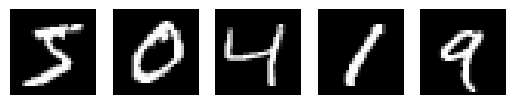

In [5]:
# parameters
batch_size = 32

# transform object that pre-processes the data
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=0.5, std=0.5)
])

# data loader object
loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform), 
    batch_size=batch_size, shuffle=True)

# show a few samples
n = 5
for i in range(n): 
    plt.subplot(1, n, i+1)
    x = loader.dataset.data[i]
    plt.imshow(x.numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Note that we only load the training data, as testing is not really necessary for generative models. The objective of a generative model is to generate good samples, not to maximize clustering or classification performance. To define an objective function for a generative model, remains an open problem up to now. 

Also denote that we apply a transformation that converts the data to tensors and normalizes the data to the $[-1,1]$ range. We will exploit this in our network architecture to simplify data generation. 

We can now start building the generative adversarial network. As seen in the theory, the architecture consists of a generator and discriminator. Both networks consist of 4 linear layers with [leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activation (except for the output activations). The generator transforms a latent noise vector into an vector represented image. The discriminator takes an image as input and computes the likelihood that this sample is real. Note that the output activation of the generator is a [tanh](https://pytorch.org/docs/stable/generated/torch.tanh.html) function (conform with the inputs that have been scaled to $[-1,1]$), and the output activation of the discriminator is a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) function to correspond with a probability. The image below shows the complete GAN architecture (top: generator, bottom: discriminator) in full detail. 

![GAN scheme](https://i.ibb.co/v15VJph/scheme2.png)

**Exercise**: Implement the above GAN architecture: 
- Implement the initialization and forward functions of the Generator and Discriminator classes. 
- Print out the architecture

In [6]:
class Generator(nn.Module):

    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()

        # save variable for future use
        self.input_size = input_size
        self.output_size = output_size

        # parameters
        self.init_features = 256
        self.negative_slope = 0.2

        self.fc1 = nn.Linear(input_size, self.init_features)
        self.fc2 = nn.Linear(self.init_features, 2*self.init_features)
        self.fc3 = nn.Linear(2*self.init_features, 4*self.init_features)
        self.fc4 = nn.Linear(4*self.init_features, output_size)
        self.leaky_relu = nn.LeakyReLU(self.negative_slope)

    def forward(self, x):

        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))

        return x

class Discriminator(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()

        # save variable for future use
        self.input_size = input_size
        self.output_size = output_size

        # parameters
        self.init_features = 1024
        self.negative_slope = 0.2
        self.dropout_prob = 0.3

        self.fc1 = nn.Linear(input_size, self.init_features)
        self.fc2 = nn.Linear(self.init_features, self.init_features // 2)
        self.fc3 = nn.Linear(self.init_features // 2, self.init_features // 4)
        self.fc4 = nn.Linear(self.init_features // 4, output_size)
        self.leaky_relu = nn.LeakyReLU(self.negative_slope)
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, x):

        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.dropout(self.leaky_relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))

        return x

# parameters
z_dim = 64
wnd_sz = 28

# networks
G = Generator(input_size=z_dim, output_size=wnd_sz**2).to(device)
D = Discriminator(input_size=wnd_sz**2, output_size=1).to(device)

# print architecture
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
)


## 3. Training a generative adversarial network

Now comes the tricky part: training a GAN from scratch. 

**Exercise**: Train the GAN network on the MNIST dataset. The code below has most components filled to train a GAN network. Take your time and go through it. In each epoch, the discriminator is first trained w.r.t. its loss function. Next, the generator is updated w.r.t. its loss function. At the end of each epoch, the generator computes its generated images from a fixed noise vector and you will see the generated results. Keep in mind that an epoch might require a few seconds to finish due to the many forward and backward passes. 
- Complete the `train_discriminator` function by implementing what is mentioned in the comments. 
- Complete the `train_generator` function by implementing what is mentioned in the comments. 
- Analyse how the generated samples evolve during training
- Study the training curves and explain why the discriminator/generator loss increases/decreases. Note that we plot half of the discriminator loss because this is originally the sum of the losses for a real and fake sample. 

Epoch 0: Discriminator loss = 1.210 - Generator loss = 1.500


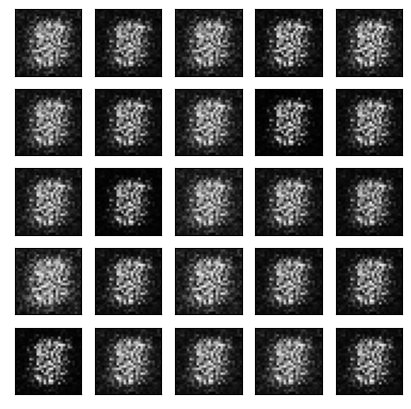

Epoch 1: Discriminator loss = 0.695 - Generator loss = 2.449


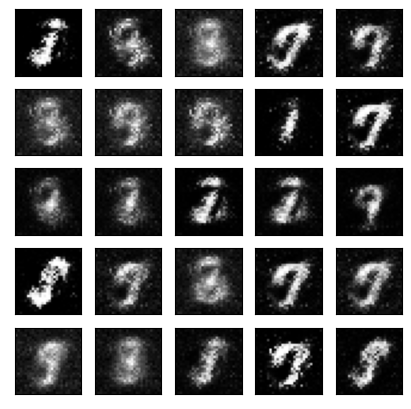

Epoch 2: Discriminator loss = 0.688 - Generator loss = 2.134


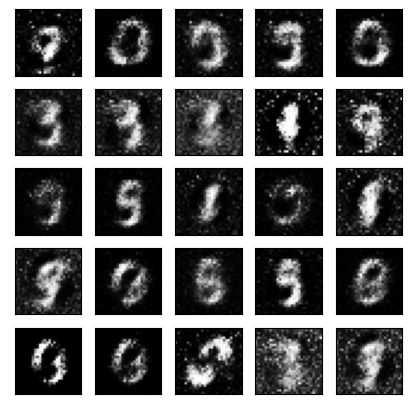

Epoch 3: Discriminator loss = 0.792 - Generator loss = 1.877


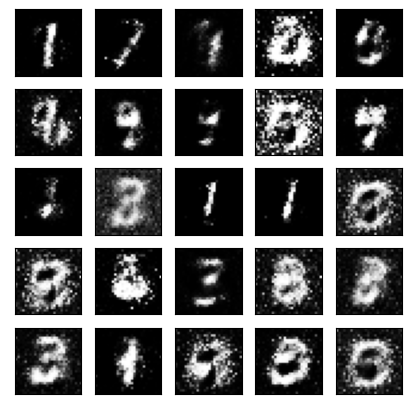

Epoch 4: Discriminator loss = 0.884 - Generator loss = 1.632


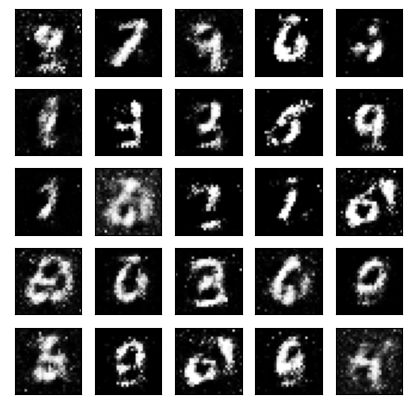

Epoch 5: Discriminator loss = 0.951 - Generator loss = 1.484


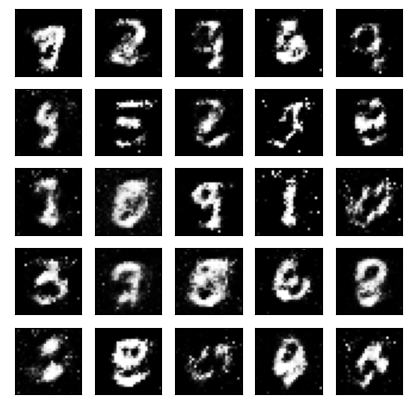

Epoch 6: Discriminator loss = 0.965 - Generator loss = 1.461


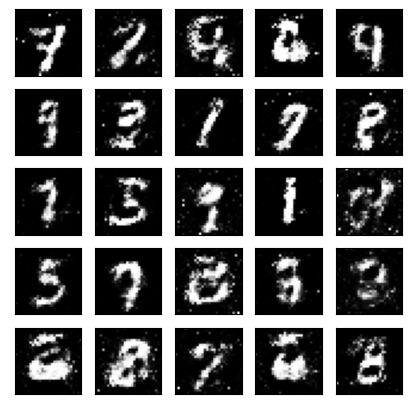

Epoch 7: Discriminator loss = 1.022 - Generator loss = 1.322


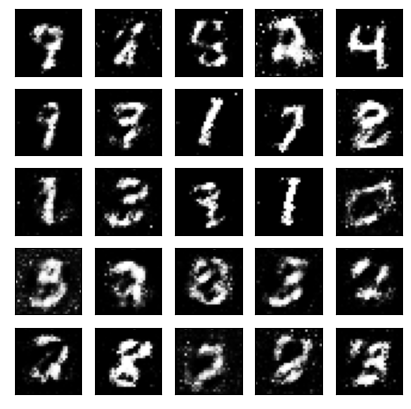

Epoch 8: Discriminator loss = 1.057 - Generator loss = 1.267


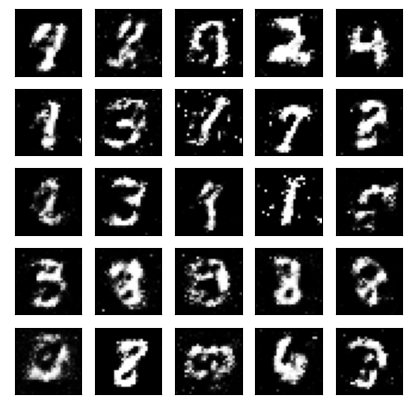

Epoch 9: Discriminator loss = 1.081 - Generator loss = 1.226


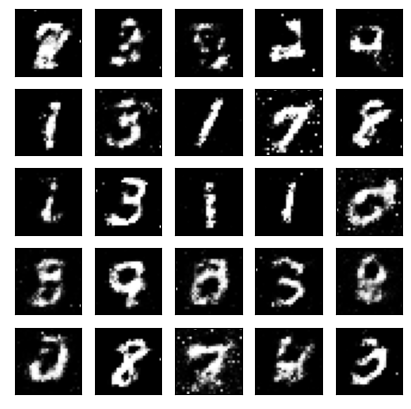

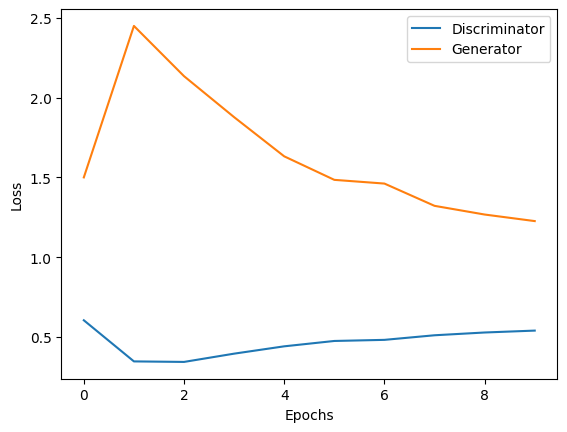

In [7]:
# show the generated samples that correspond to a (5x5) batch of noise vectors
def show_generated_samples(G, z):

    # set generator to evaluation mode and run it
    G.eval()
    test_images = G(z)

    # figure stuff
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i in range(size_figure_grid):
        for j in range(size_figure_grid):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

    # visualize the generated images
    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().detach().view(28, 28).numpy(), cmap='gray')
    plt.show()

# train the discriminator for a single iteration
def train_discriminator(D, G, x, D_optimizer): 

    # zero the gradients
    D.zero_grad()

    # domain labels: real corresponds to 1, fake corresponds to 0
    y_real = torch.ones(x.size(0)).to(device)
    y_fake = torch.zeros(x.size(0)).to(device)

    # run the discriminator on the real sample and compute the loss
    D_real = D(x)
    D_real_loss = BCE_loss(D_real.flatten(), y_real)

    # generate a fake sample
    z = torch.randn((x.size(0), G.input_size)).to(device)
    x_ = G(z)

    # run the discriminator on the fake sample and compute the loss
    D_fake = D(x_)
    D_fake_loss = BCE_loss(D_fake.flatten(), y_fake)

    # sum the real and fake loss
    D_train_loss = D_real_loss + D_fake_loss

    # backpropagation on the discriminator and parameter update
    D_train_loss.backward()
    D_optimizer.step()

    discriminator_loss = D_train_loss.item()

    return discriminator_loss

# train the generator for a single iteration
def train_generator(D, G, G_optimizer): 

    # zero the gradients
    G.zero_grad()
    
    # domain labels: real corresponds to 1, fake corresponds to 0
    y = torch.ones(batch_size).to(device)


    # generate a fake sample
    z = torch.randn((batch_size, G.input_size)).to(device)
    x_fake = G(z)

    # run the discriminator on the fake sample and compute the loss
    D_fake = D(x_fake)
    G_fake_loss = BCE_loss(D_fake.flatten(), y) # attempting fake sample to be real

    # backpropagation on the generator and parameter update
    G_fake_loss.backward()
    G_optimizer.step()

    generator_loss = G_fake_loss.item()

    return generator_loss

# train the GAN network for a number of epochs
def train_gan(D, G, loader, D_optimizer, G_optimizer, epochs, fixed_z):

    loss_d = np.zeros((epochs))
    loss_g = np.zeros((epochs))
    for epoch in range(epochs):

        # set generator and discriminator to training mode
        G.train()
        D.train()

        for x, _ in loader:
            
            # get a batch of samples
            x = x.view(-1, 28 * 28).to(device).float()

            # train discriminator D and cumulate loss
            loss = train_discriminator(D, G, x, D_optimizer)
            loss_d[epoch] += loss

            # train generator G and cumulate loss
            loss = train_generator(D, G, G_optimizer)
            loss_g[epoch] += loss

        # average losses and report
        loss_d[epoch] /= len(loader)
        loss_g[epoch] /= len(loader)
        print('Epoch %d: Discriminator loss = %.3f - Generator loss = %.3f' % (epoch, loss_d[epoch], loss_g[epoch]))

        # show generated samples
        show_generated_samples(G, fixed_z)

    return loss_d, loss_g


# training parameters
lr = 2e-4
epochs = 10

# binary cross entropy loss is used in a GAN
BCE_loss = nn.BCELoss()

# adam optimizer for both networks
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

# fixed noise (for consistency in comparing generated samples)
fixed_z = torch.randn((5 * 5, G.input_size)).to(device)

# train the network
loss_d, loss_g = train_gan(D, G, loader, D_optimizer, G_optimizer, epochs, fixed_z)

# visualize the learning curves
plt.plot(loss_d / 2)
plt.plot(loss_g)
plt.legend(('Discriminator', 'Generator'))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

At the early stage, there seems to be little variance in the generated samples. Often we see consistently generated numbers, e.g. zeros or nines. This phenomenon is called mode collapse and meanse that the generator has focused on one or multiple groups (or modes) in the data (typically the easier ones to generate). After 10 epochs, we start seeing more variance in the data and close to realistic samples. 

The training curve seems to be converging to a stable state. The generator consistently decreases, meaning that is succeeding to confuse the discriminator, i.e. more and more realistic samples are generated. The consequence for the discriminator is that it cannot differentiate between real and fake samples, meaning that its loss will increase. The result is that the generator and discriminator converge to a stable equilibrium. 

Obviously, you could let this run for a longer time period and improve the quality of the samples. This is the result that you can obtain after 50 epochs of training. 

![GAN results MNIST 50 epochs](https://i.ibb.co/sQbjwSs/gan-result-mnist.png)

Keep in mind that training GAN networks can be tedious and time-consuming. Hyperparameter settings and architectural choices such as where to include dropout and normalization are crucial. Feel free to try this out by e.g. removing the dropout layers, changing the learning rate, etc.  

## 4. Adaptation to electron microscopy data

We will now adapt the GAN for digit image generation to a generative model for electron microscopy data. Specifically, the data used originates from the ISBI 2012 segmentation challenge on neuron structures (see third exercise session). As our model is unsupervised, we will not used the labels provided in the dataset. We briefly visualize a slice of the data. 

Size of the volume: 30 x 512 x 512


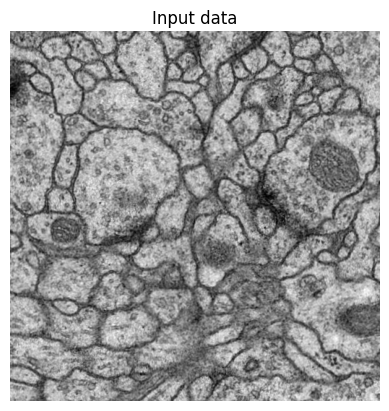

In [8]:
# specify where the data is stored
data_dir = 'data-3'

# load the datadispensers
x = read_tif(os.path.join(data_dir, 'train-volume.tif'))

# print out size
print('Size of the volume: %d x %d x %d' % x.shape)

# show example
plt.imshow(x[0], cmap='gray')
plt.title('Input data')
plt.axis('off')
plt.show()

We will try to re-use the code from the MNIST dataset as much as possible. To make our lives easier, we will therefore attempt to generate EM samples of size $28 \times 28$ as well. To do this, we need a data loader that samples random windows of this size from the data volume. 

**Exercise**: Implement a data loader that returns windows of size $28 \times 28$. 
- Implement the `__init__`, `__getitem__` and `__len__` function of the `EMWindowDataset` class. The initializer should save variables that are necessary for sampling (e.g. the window size). The length of the dataset can simply be a fixed number of iterations (e.g. $10^4$). For sampling, you should pick a random location in the volume and return a window of size $28 \times 28$. 
- Make sure that your sampled window is rescaled to the $[-1, 1]$ interval, as with the MNIST data. 
- The additional code below shows the result of your sampling operation. 

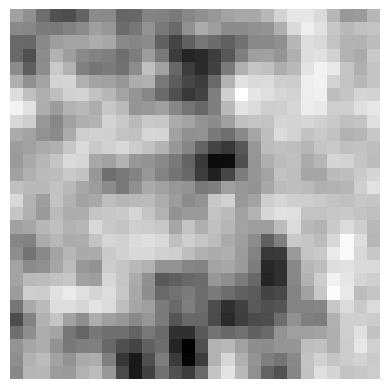

In [9]:
# dataset useful for sampling (and many other things)
class EMWindowDataset(data.Dataset):
    
    def __init__(self, x, wnd_sz, max_iter_epoch):

        # window size
        self.wnd_sz = wnd_sz
        
        # size of the data
        self.size = x.shape

        # maximum number of iterations per epoch
        self.max_iter_epoch = max_iter_epoch

        self.x = x
    
    def __getitem__(self, i):

        # delinearize the index
        z = np.random.randint(0, self.size[0])
        y = np.random.randint(0, self.size[1] - self.wnd_sz[0] + 1)
        x = np.random.randint(0, self.size[2] - self.wnd_sz[1] + 1)

        # extract the window
        wnd = self.x[z, y:y + self.wnd_sz[0], x:x + self.wnd_sz[1]]

        return wnd
    
    def __len__(self):
        return self.max_iter_epoch

# parameters
window_size = (28, 28)
max_iter_epoch = 10**4

# make an instance of the dataset
x = x / 255  # rescale to [0, 1]
x = (x - 0.5) * 2  # rescaling to [-1, 1]
train = EMWindowDataset(x, window_size, max_iter_epoch)

# test the class
wnd = train[0]
plt.imshow(wnd, cmap='gray')
plt.axis('off')
plt.show()

# setup the data loader
loader = DataLoader(train, batch_size=batch_size)

Now we are reade to train the GAN on EM data! 

**Exercise**: Below is the `train_gan` function of the MNIST dataset. The only thing you will have to adjust is the data loading step. Keep in mind that the MNIST dataset returns a tuple (the input and a label), whereas our data loader returns only the necessary image. To train the network, we recommend to reduce the learning rate to $10^{-5}$ and increase the amount of epochs to $20$. 

In [10]:
# train the GAN network for a number of epochs
def train_gan(D, G, loader, D_optimizer, G_optimizer, epochs, fixed_z):

    loss_d = np.zeros((epochs))
    loss_g = np.zeros((epochs))
    for epoch in range(epochs):

        # set generator and discriminator to training mode
        G.train()
        D.train()

        for x in loader:
            
            # get a batch of samples
            x = x.view(-1, 28 * 28).to(device).float()

            # train discriminator D and cumulate loss
            loss = train_discriminator(D, G, x, D_optimizer)
            loss_d[epoch] += loss

            # train generator G and cumulate loss
            loss = train_generator(D, G, G_optimizer)
            loss_g[epoch] += loss

        # average losses and report
        loss_d[epoch] /= len(loader)
        loss_g[epoch] /= len(loader)
        print('Epoch %d: Discriminator loss = %.3f - Generator loss = %.3f' % (epoch, loss_d[epoch], loss_g[epoch]))

        # show generated samples
        show_generated_samples(G, fixed_z)

    return loss_d, loss_g


# parameters
z_dim = 64
wnd_sz = 28
lr = 1e-4
epochs = 20

# networks
G = Generator(input_size=z_dim, output_size=wnd_sz**2).to(device)
D = Discriminator(input_size=wnd_sz**2, output_size=1).to(device)

# binary cross entropy loss is used in a GAN
BCE_loss = nn.BCELoss()

# adam optimizer for both networks
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

# fixed noise (for consistency in comparing generated samples)
fixed_z = torch.randn((5 * 5, G.input_size)).to(device)

# train the network
loss_d, loss_g = train_gan(D, G, loader, D_optimizer, G_optimizer, epochs, fixed_z)

# visualize the learning curves
plt.plot(loss_d / 2)
plt.plot(loss_g)
plt.legend(('Discriminator', 'Generator'))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

You should obtain decent sample generation quality after 20 epochs. This is the result that you can obtain after 50 epochs. 

![GAN results EM](https://i.ibb.co/R9KtgNh/gan-result-em.png)

Lastly, these models allow you to interpolate in a very realistic sense between generated samples. Consider two random noise vectors $\mathbf{z}$ and $\mathbf{z}'$, and their corresponding generated samples, $\mathbf{x}=G(\mathbf{z})$ and $\mathbf{x}'=G(\mathbf{z}')$, respectively. An interpolated sample between the two is then obtained by interpolating in the latent space and decoding with the generator, i.e. $\mathbf{x}_\alpha=G(\alpha \mathbf{z} + (1 - \alpha) \mathbf{z}')$. The code below shows this visually. 

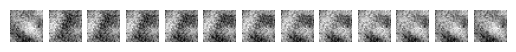

In [11]:
# generate z and z'
z = torch.randn((1, G.input_size)).to(device)
z_ = torch.randn((1, G.input_size)).to(device)

# generate interpolations between z and z'
n = 12
zi = torch.zeros((n, G.input_size)).to(device)
for i in range(1, n+1): 
    alpha = i / (n+1)
    zi[i-1] = alpha * z[0] + (1 - alpha) * z_[0]

# concatenate all samples in a single batch
z_all = torch.cat((z, zi, z_), dim=0)

# decode the samples with the generator
x_all = G(z_all)

# visualize samples
for i in range(n+1): 
    plt.subplot(1, n+1, i+1)
    plt.imshow(x_all[i].detach().cpu().view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

We see a fluent transition from one image to the other, which shows our generative model has successfully learned the generating distribution! 